### Description:
The tasks is building a model that can identify whether a tweet is about a real disaster or not. This is a binary classification problem in the field of Natural Language Processing (NLP), which involves teaching machines to understand and process human language.

NLP techniques are used to clean, analyze, and model the text data (tweets) to extract meaningful patterns that can distinguish disaster-related messages from irrelevant ones. Techniques include tokenization, stop word removal, vectorization, and using RNN-based models for sequential understanding of language.

Data Overview:
Training Data (train.csv):
Size: 7,613 rows × 5 columns

Columns:

id: Unique identifier for each tweet

keyword: Optional keyword from the tweet (may be missing)

location: Optional user location (may be missing)

text: The tweet content (primary input for NLP)

target: Binary label, 1 for real disaster, 0 for not

Test Data (test.csv):
Size: 3,263 rows × 4 columns (same as training data but without target)


[GitHub Repo](https://github.com/Bilal1k/DisasterNlpRnn)

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
import re
from bs4 import BeautifulSoup
import string
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence
import numpy as np

In [28]:
data = pd.read_csv('./data/nlp/train.csv')
test = pd.read_csv("./data/nlp/test.csv")
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [29]:
data.shape, test.shape

((7613, 5), (3263, 4))

In [30]:
print(f"Number of NAs in the keyword column: {sum(data['keyword'].isna())}")
print(f"Number of NAs in the location column: {sum(data['location'].isna())}")
print(data['keyword'][data['keyword'].notna()].head())
print(data['location'][data['location'].notna()].head())

Number of NAs in the keyword column: 61
Number of NAs in the location column: 2533
31    ablaze
32    ablaze
33    ablaze
34    ablaze
35    ablaze
Name: keyword, dtype: object
31                       Birmingham
32    Est. September 2012 - Bristol
33                           AFRICA
34                 Philadelphia, PA
35                       London, UK
Name: location, dtype: object


### Omitting keyword and location:
The keyword and location fields will be excluded from the model because they often contain noisy, incomplete, or non-standardized data. Many entries in both fields are missing, inconsistent, or irrelevant to the actual content of the tweet. Additionally, the main semantic information required to distinguish disaster-related tweets is already well-represented in the text field, which allows the model to learn context and intent directly from natural language. Including keyword and location risked introducing sparsity or misleading signals without significant predictive gain.

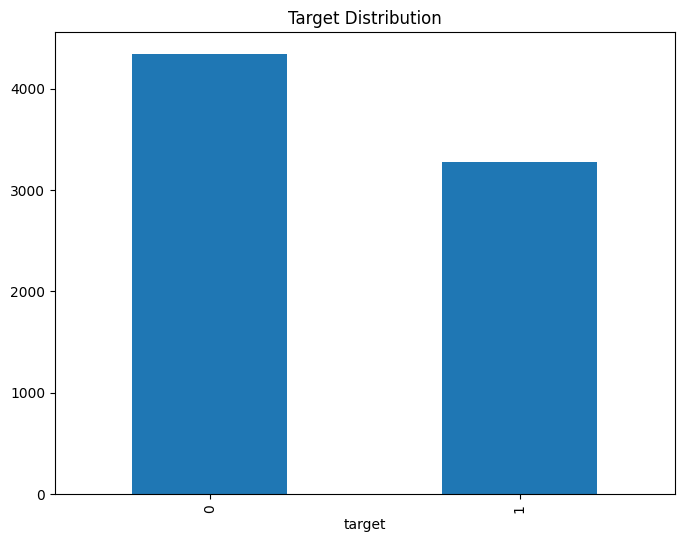

In [9]:
# Target balance
plt.figure(figsize=(8,6))
data['target'].value_counts().plot(kind='bar', title='Target Distribution')
plt.show()

### Cleaning
To prepare the tweet text for modeling, I implemented a comprehensive text cleaning pipeline. This process expanded common contractions, removed noise such as emojis, URLs, email addresses, HTML tags, and punctuation, and standardized common acronyms. Words containing numbers and stopwords were also removed to reduce irrelevant tokens.

In [10]:
# Contractions from http://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions thanks to @arturomp from https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [11]:
# Data Cleaning and Preprocessing
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def scrub_text(text, contractions: dict):
    """
    Cleans text by expanding contractions, removing emojis, URLs, emails,
    acronyms, punctuation, stopwords, and extra spaces.

    Parameters:
        text (str): Input text to clean.
        contractions (dict): dictionary containing contractions mapping.

    Returns:
        str: Cleaned text.
    """

    # Expand contractions in the text
    expanded_text = ' '.join(contractions.get(word, word) for word in text.split())

    # Remove HTML tags using BeautifulSoup
    clean_text = BeautifulSoup(expanded_text, 'html.parser').get_text()

    # Remove email addresses
    clean_text = re.sub(r'[\w\.-]+@[\w\.-]+\.\w+', ' ', clean_text)

    # Remove emojis
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
    )
    clean_text = emoji_pattern.sub('', clean_text)

    # Expand common acronyms
    acronyms = {
        r"mh370": "missing malaysia airlines flight",
        r"okwx": "oklahoma city weather",
        r"arwx": "arkansas weather",
        r"gawx": "georgia weather",
        r"scwx": "south carolina weather",
        r"cawx": "california weather",
        r"tnwx": "tennessee weather",
        r"azwx": "arizona weather",
        r"alwx": "alabama weather",
        r"wordpressdotcom": "wordpress",
        r"usnwsgov": "united states national weather service",
        r"suruc": "sanliurfa"
    }

    for acronym, expansion in acronyms.items():
        clean_text = re.sub(acronym, expansion, clean_text)

    # Remove URLs
    clean_text = re.sub(r'https?://(www\.)?(\w+)(\.\w+)(/\w*)?', '', clean_text)

    # Remove words containing numbers
    clean_text = re.sub(r'\w*\d\w*', '', clean_text)

    # Remove punctuation
    clean_text = ''.join([char.lower() for char in clean_text if char not in string.punctuation])

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    clean_text = ' '.join(word for word in clean_text.split() if word.isalpha() and word not in stop_words)

    # Remove extra spaces
    clean_text = re.sub(' +', ' ', clean_text).strip()

    return clean_text


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bilal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
data['clean_text'] = data['text'].apply(lambda x: scrub_text(text = x, contractions=contractions))

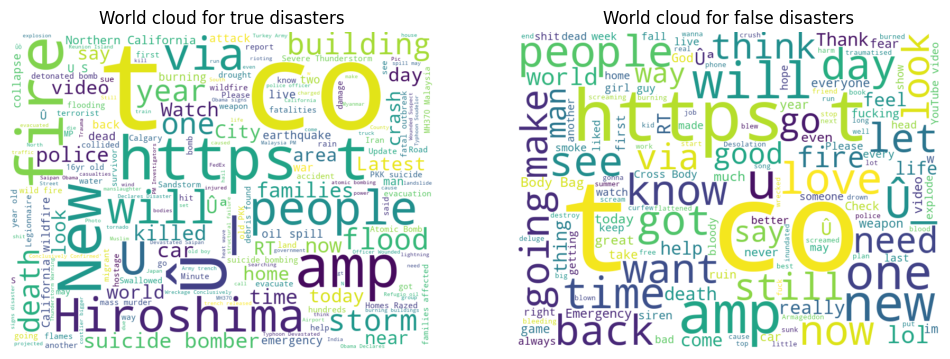

In [13]:
# Word clouds for true and false disasters
disaster = data[data.target == 1]['text']
disaster_string = ' '.join(disaster)
wcp = WordCloud(max_words=200, width=800, height=600, background_color="white").generate(disaster_string)

false_disaster = data[data.target == 0]['text']
false_disaster_string = ' '.join(false_disaster)
wcn = WordCloud(max_words=150, width=800, height=600, background_color="white").generate(false_disaster_string)

fig, (fig1, fig2) = plt.subplots(1,2, figsize=(12, 12))

fig1.imshow(wcp, interpolation='bilinear')
fig1.set_title('World cloud for true disasters')
fig1.axis('off')

fig2.imshow(wcn, interpolation='bilinear')
fig2.set_title('World cloud for false disasters')
fig2.axis('off')

plt.show()

### Encoding Method Description:
This approach uses a Bag-of-Words encoding with CountVectorizer, which converts text data into fixed-length numeric feature vectors. It tokenizes each tweet and builds a vocabulary of the top 5,000 most frequent words across the entire dataset. Each tweet is then represented as a 5000-dimensional vector, where each element indicates the frequency of a specific word in that tweet. While this method is simple, easy to implement and effective, it lacks context-awareness or word semantics.

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [14]:
# Encoding texts using Embeddings
vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(data['clean_text']).toarray()
y = data['target'].values

In [15]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# PyTorch Dataset and Dataloader
class DisasterDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = DisasterDataset(X_train, y_train)
val_dataset = DisasterDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

### Model Description:
GRU based RNN for Disaster Tweet Classification
we used a sequential neural network model built using PyTorch. It is designed to classify whether a tweet refers to a real disaster. The architecture is as follows:

GRU Layer (nn.GRU): This is the core of the model—a Gated Recurrent Unit (GRU), which is a type of recurrent neural network (RNN) that captures sequential dependencies in the input text. It is configured with:

input_size: Dimensionality of the input vectors

hidden_size: Number of hidden units per GRU cell.

num_layers: Number of stacked GRU layers.

dropout: Applied between GRU layers (except the last one) to reduce overfitting.

Dropout Layer (nn.Dropout): Applied after the GRU to regularize the model by randomly zeroing some of the outputs.

Fully Connected Layer (nn.Linear): Maps the final hidden state of the GRU to a single output node representing the probability of the tweet being disaster-related.

Sigmoid Activation (torch.sigmoid): Converts the output to a probability between 0 and 1 for binary classification.

In [17]:
# GRU RNN model
class DisasterRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(DisasterRNN, self).__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x.unsqueeze(1))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return torch.sigmoid(out)

### Hyperparameter Tuning
To optimize model performance, we performed a grid search over several key hyperparameters of the GRU-based neural network. These included the hidden layer size ([32, 64]), the number of GRU layers ([2, 3]), learning rate ([0.001, 0.01]), and dropout rate ([0.3, 0.2, 0.1]). For each unique combination, the model was trained for 3 epochs and evaluated on a validation set. The validation accuracy was recorded to compare model configurations and identify the best-performing parameter set.


Our initial best configuration achieved a validation accuracy of ~77.7% using hidden_size=32, num_layers=2, and lr=0.001—without dropout. We then introduced dropout regularization to combat overfitting observed in the validation curves. After tuning the dropout rate, we found that a moderate rate of 0.2 provided a slight improvement in validation F1-score and stability across epochs. This confirmed that regularization helped the model generalize better. Performance metrics were tracked using F1-score and loss curves, which showed a slight reduced overfitting after applying dropout. Overfitting is still an issue but it is more likely related to encoding or the model design itself rather than hyperparameter tuning.

In [25]:
# Hyperparameter tuning 
hidden_sizes = [32, 64]
num_layers_options = [2, 3]
learning_rates = [0.001, 0.001, 0.01]
dropout_rates = [0.3, 0.2, 0.1]
results = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for hidden_size in hidden_sizes:
    for num_layers in num_layers_options:
        for lr in learning_rates:
            for dropout in dropout_rates:
                model = DisasterRNN(input_size=5000, hidden_size=hidden_size, num_layers=num_layers,dropout_rate=dropout)
                model.to(device)
                criterion = nn.BCELoss()
                optimizer = optim.Adam(model.parameters(), lr=lr)

                for epoch in range(3):  # Small epochs for demonstration
                    model.train()
                    for inputs, labels in train_loader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        outputs = model(inputs)
                        loss = criterion(outputs.squeeze(), labels)
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # Validation
                model.eval()
                val_preds = []
                val_targets = []
                with torch.no_grad():
                    for inputs, labels in val_loader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        outputs = model(inputs).squeeze()
                        val_preds.extend(outputs.round().numpy())
                        val_targets.extend(labels.numpy())

                acc = accuracy_score(val_targets, val_preds)
                results.append((hidden_size, num_layers, lr, dropout, acc))
                print(f'Hidden Size: {hidden_size}, Num Layers: {num_layers}, Learning rate: {lr}, dropout: {dropout}, Accuracy: {acc}')

# Display results
results_df = pd.DataFrame(results, columns=['Hidden Size', 'Num Layers', 'lr' , 'dropout', 'Accuracy'])

Hidden Size: 32, Num Layers: 2, Learning rate: 0.001, dropout: 0.3, Accuracy: 0.7977675640183848
Hidden Size: 32, Num Layers: 2, Learning rate: 0.001, dropout: 0.2, Accuracy: 0.7931713722915299
Hidden Size: 32, Num Layers: 2, Learning rate: 0.001, dropout: 0.1, Accuracy: 0.793827971109652
Hidden Size: 32, Num Layers: 2, Learning rate: 0.001, dropout: 0.3, Accuracy: 0.793827971109652
Hidden Size: 32, Num Layers: 2, Learning rate: 0.001, dropout: 0.2, Accuracy: 0.7951411687458962
Hidden Size: 32, Num Layers: 2, Learning rate: 0.001, dropout: 0.1, Accuracy: 0.7839789888378201
Hidden Size: 32, Num Layers: 2, Learning rate: 0.01, dropout: 0.3, Accuracy: 0.7695338148391333
Hidden Size: 32, Num Layers: 2, Learning rate: 0.01, dropout: 0.2, Accuracy: 0.7734734077478661
Hidden Size: 32, Num Layers: 2, Learning rate: 0.01, dropout: 0.1, Accuracy: 0.7787261982928431
Hidden Size: 32, Num Layers: 3, Learning rate: 0.001, dropout: 0.3, Accuracy: 0.8069599474720945
Hidden Size: 32, Num Layers: 3, Lea

KeyboardInterrupt: 

In [24]:
hidden_size = results_df['Hidden Size'][results_df['Accuracy'] == results_df['Accuracy'].max()].to_list()[0]
num_layers = results_df['Num Layers'][results_df['Accuracy'] == results_df['Accuracy'].max()].to_list()[0]
lr = results_df['lr'][results_df['Accuracy'] == results_df['Accuracy'].max()].to_list()[0]
dropout = results_df['dropout'][results_df['Accuracy'] == results_df['Accuracy'].max()].to_list()[0]
results_df[results_df['Accuracy']== results_df['Accuracy'].max()]

,Hidden Size,Num Layers,lr,dropout,Accuracy
4,32,2,0.001,0.2,0.797111


In [20]:
final_model = DisasterRNN(input_size=5000, hidden_size=int(hidden_size), num_layers=int(num_layers), dropout_rate=dropout)
criterion = nn.BCELoss()
optimizer = optim.Adam(final_model.parameters(), lr=lr)
final_model.to(device)
epochs = 5

train_losses, val_losses, train_f1s, val_f1s = [], [], [], []

for epoch in range(epochs):
    final_model.train()
    train_preds, train_targets = [], []
    epoch_train_loss = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = final_model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        train_preds.extend(outputs.round().detach().numpy())
        train_targets.extend(labels.numpy())

    epoch_train_loss /= len(train_loader)
    train_f1 = f1_score(train_targets, train_preds)

    final_model.eval()
    val_preds, val_targets = [], []
    epoch_val_loss = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = final_model(inputs).squeeze()
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()
            val_preds.extend(outputs.round().numpy())
            val_targets.extend(labels.numpy())

    epoch_val_loss /= len(val_loader)
    val_f1 = f1_score(val_targets, val_preds)

    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}")

Epoch 1, Train Loss: 0.6647, Val Loss: 0.6061, Train F1: 0.1433, Val F1: 0.4044
Epoch 2, Train Loss: 0.4755, Val Loss: 0.4526, Train F1: 0.7237, Val F1: 0.7471
Epoch 3, Train Loss: 0.3446, Val Loss: 0.4648, Train F1: 0.8241, Val F1: 0.7549
Epoch 4, Train Loss: 0.2761, Val Loss: 0.4982, Train F1: 0.8666, Val F1: 0.7510
Epoch 5, Train Loss: 0.2329, Val Loss: 0.5500, Train F1: 0.8909, Val F1: 0.7389


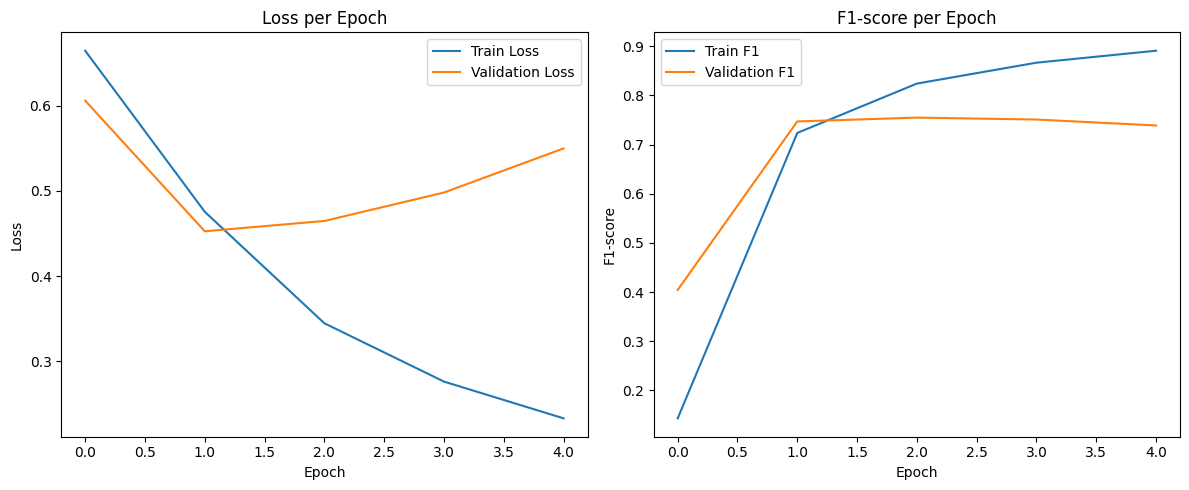

In [26]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_f1s, label='Train F1')
plt.plot(val_f1s, label='Validation F1')
plt.title('F1-score per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.legend()

plt.tight_layout()
plt.show()


### Conclusion:
The model demonstrated rapid learning during the first epoch but showed signs of overfitting starting from the second epoch, as seen in the diverging loss and F1-score curves. While the training F1-score steadily improved, validation performance plateaued and then declined, indicating the model was fitting the training data too closely without generalizing well. One limiting factor was the use of CountVectorizer for text encoding, which captures only frequency-based word presence and ignores semantic context or word order. Incorporating pre-trained embeddings like GloVe which encode richer semantic relationships could have substantially improved model performance. Additionally, exploring more complex architectures (e.g., bidirectional GRUs, LSTMs, or transformer-based models) and using techniques like early stopping or learning rate scheduling could help mitigate overfitting. Future work should prioritize context-aware embeddings and architecture refinement to improve generalization on unseen data.

In [ ]:
test['clean_text'] = test['text'].apply(lambda x: scrub_text(text = x, contractions=contractions))

test_vectors = vectorizer.transform(test['clean_text']).toarray()
test_dataset = torch.tensor(test_vectors, dtype=torch.float32)

final_model.eval()
test_predictions = []
with torch.no_grad():
    for i in range(len(test_dataset)):
        input_tensor = test_dataset[i].unsqueeze(0)
        output = final_model(input_tensor).item()
        test_predictions.append(round(output))

# Storing predictions in a dataframe
submission = pd.DataFrame({
    'id': test['id'],
    'target': test_predictions
})

submission.to_csv('submission.csv', index=False)
print("Predictions saved to submission.csv")